<a href="https://colab.research.google.com/github/FlorianGelb/GNNProject/blob/K_sparse/K_SAE_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets
from torch.utils.data import Dataset,DataLoader,random_split,Subset
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

In [ ]:
import os
os.chdir("/content/drive/MyDrive/GNNProject/DataPreparation")

In [ ]:
data = pd.read_csv('CorruptedFashionMNIST2/Names.csv')
transform = transforms.ToTensor()

In [ ]:
class FashionMNISTDataset(Dataset):
    def __init__(self,dataframe,root_dir,transform=None):
        self.dataframe=dataframe
        self.root_dir = root_dir
        self.transform=transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self,idx):
        img_name=os.path.join(self.root_dir,self.dataframe.iloc[idx,0])
        image=Image.open(img_name)
        label=self.dataframe.iloc[idx,1]
        if self.transform:
            image=self.transform(image)
        return image,label

In [ ]:
root_dir = 'CorruptedFashionMNIST2'
dataset = FashionMNISTDataset(dataframe=data,root_dir=root_dir,transform=transform)


In [ ]:
subset_size=int(0.3 * dataset.__len__())

In [ ]:
'''
original = datasets.FashionMNIST("./", download=True)

new_dataset = []
for i in range(subset_size):
    item = dataset.__getitem__(i)
    add = transform(original[i][0])
    new_item = item + (add,)
    new_dataset.append(new_item)
dataset=new_dataset
'''

'\noriginal = datasets.FashionMNIST("./", download=True)\n\nnew_dataset = []\nfor i in range(subset_size):\n    item = dataset.__getitem__(i)\n    add = transform(original[i][0])\n    new_item = item + (add,)\n    new_dataset.append(new_item)\ndataset=new_dataset\n'

In [ ]:

indices = torch.randperm(len(dataset)).tolist()
subset_indices = indices[:subset_size]
subset_dataset = Subset(dataset, subset_indices)

In [ ]:
# Split the subset dataset into train and test sets
train_size = int(0.8 * len(subset_dataset))  # 80% for training
test_size = len(subset_dataset) - train_size  # Remaining for testing

train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# Create DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
images,_ = next(iter(train_loader))
print(images.shape)

torch.Size([64, 1, 28, 28])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split, Subset

import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


%matplotlib inline


In [ ]:
# Encoder and decoder classes

class Encoder(nn.Module):
    def __init__(self, layers_dim,k):
        super(Encoder, self).__init__()
        self.layers_dim = layers_dim
        self.k=k

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        #layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)

        raw=encoded.detach().numpy()

        k=self.k
        mask = np.ones(raw.shape, dtype=bool)
        if k < raw.shape[1]:
            for i, row in enumerate(raw):
                # Find the indices of the top k elements in each row
                indices = np.argpartition(row, -k)[-k:]

                # Update the mask to set elements at indices to False
                mask[i, indices] = False
                raw[i,mask[i]]=0
        return encoded
class Decoder(nn.Module):
    def __init__(self, layers_dim):
        super(Decoder, self).__init__()
        self.layers_dim = layers_dim

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        #layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)


    def forward(self, y):
        decoded = self.decoder(y)


        return decoded


In [ ]:
# Class for autoencoder

class Net(nn.Module):
    def __init__(self, layers,k,loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.layers = layers
        self.E = Encoder(layers,k)
        self.D= Decoder(layers[::-1])
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        code = self.E(x)
        out = self.D(code)


        return out

    def decode(self, h):
        with torch.no_grad():
            decoded=self.D(h)
            return decoded


    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss






In [ ]:

sequence = [50 - 5 * i for i in range(10)]
print(sequence)

[50, 45, 40, 35, 30, 25, 20, 15, 10, 5]


In [ ]:

layers=[28*28,128,64,50]
#models = {"15": Net(layers,15), "20": Net(layers,20),"50": Net(layers,50), "80": Net(layers,80),"128": Net(layers,128)}
models={str(k): Net(layers,k) for k in sequence}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
models["50"]

Net(
  (E): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=64, bias=True)
      (3): ReLU()
      (4): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (D): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)

In [ ]:

def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            inputs = data.clone().detach()
            output = model(inputs)

            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()

        if batch_idx % 200 == 0:
            line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)

    else:
        batch_idx += 1
        line = "Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses ".format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = " ".join(["{}: {:.6f}".format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [ ]:
avg_lambda = lambda l: "loss: {:.4f}".format(l)
line = lambda i, l: "{}: ".format(i) + avg_lambda(l) + "\t"

# Test function


def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}

    with torch.no_grad():
        for data, _ in loader:
            inputs = data.clone().detach()
            output = {k: m(inputs) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction="sum").item()


    for k in models:
        test_loss[k] /= (test_size * 784)

        if log is not None:
            log[k].append((test_loss[k]))

    lines = "\n".join([line(k, test_loss[k]) for k in models]) + "\n"
    report = "Test set:\n" + lines
    print(report)

In [ ]:
for epoch in range(1, 50):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)

    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)


Train Epoch: 1 [0/14400 (0%)]	Losses 50: 0.001874 45: 0.001917 40: 0.001848 35: 0.001897 30: 0.001829 25: 0.001931 20: 0.002067 15: 0.002310 10: 0.002838 5: 0.003341
Train Epoch: 1 [12800/14400 (89%)]	Losses 50: 0.001941 45: 0.001992 40: 0.001970 35: 0.001981 30: 0.001945 25: 0.002010 20: 0.002111 15: 0.002319 10: 0.002905 5: 0.003412
Train Epoch: 1 [14400/14400 (100%)]	Losses 50: 0.001808 45: 0.001869 40: 0.001786 35: 0.001837 30: 0.001789 25: 0.001842 20: 0.001997 15: 0.002224 10: 0.002753 5: 0.003315
Test set:
50: loss: 0.0019	
45: loss: 0.0019	
40: loss: 0.0018	
35: loss: 0.0019	
30: loss: 0.0018	
25: loss: 0.0019	
20: loss: 0.0020	
15: loss: 0.0023	
10: loss: 0.0029	
5: loss: 0.0035	

Train Epoch: 2 [0/14400 (0%)]	Losses 50: 0.001839 45: 0.001942 40: 0.001835 35: 0.001881 30: 0.001819 25: 0.001863 20: 0.002010 15: 0.002346 10: 0.002728 5: 0.003246
Train Epoch: 2 [12800/14400 (89%)]	Losses 50: 0.001800 45: 0.001872 40: 0.001806 35: 0.001845 30: 0.001815 25: 0.001890 20: 0.001967 15

In [ ]:
for k in models:
  torch.save(models[k].state_dict(), f'FashionMINST_weights_{k}_Relu_128*64*50.pth')


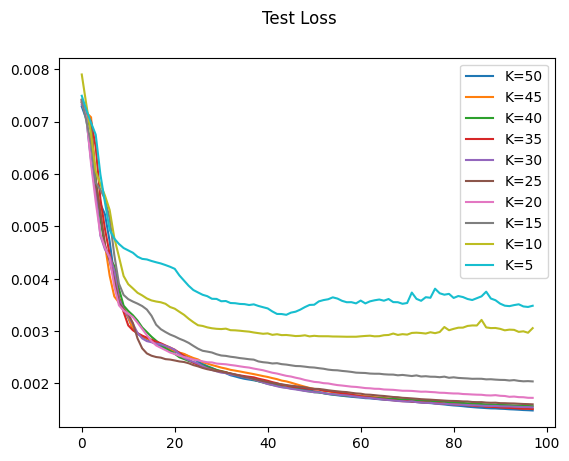

In [ ]:
for k in test_log:
    plt.plot(test_log[k], label=f'K={k}')

plt.legend()
plt.suptitle('Test Loss')
plt.show()


In [ ]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:

iter_data=iter(test_loader)

In [ ]:
data, _ = next(iter_data)
to_plots={k: [] for k in models}
encode={k: [] for k in models}
for k in models:
  output = models[k](data)

  to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
  to_plots[k].append(to_plot)

  x = data.view(-1, 28*28)
  encode[k].append(models[k].E(x))


In [ ]:
def plot_mnist(images,title, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=150)
    num_images = min(len(images), shape[0] * shape[1])

    for j in range(1, num_images + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap='gray')
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.suptitle(title)
    plt.show()

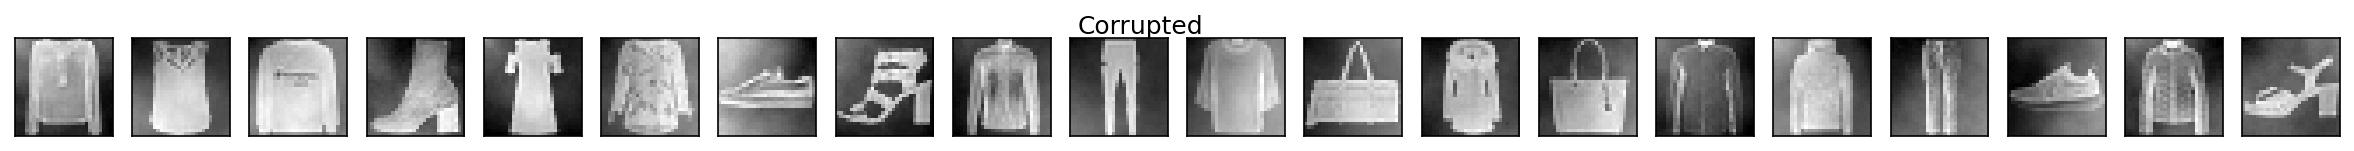

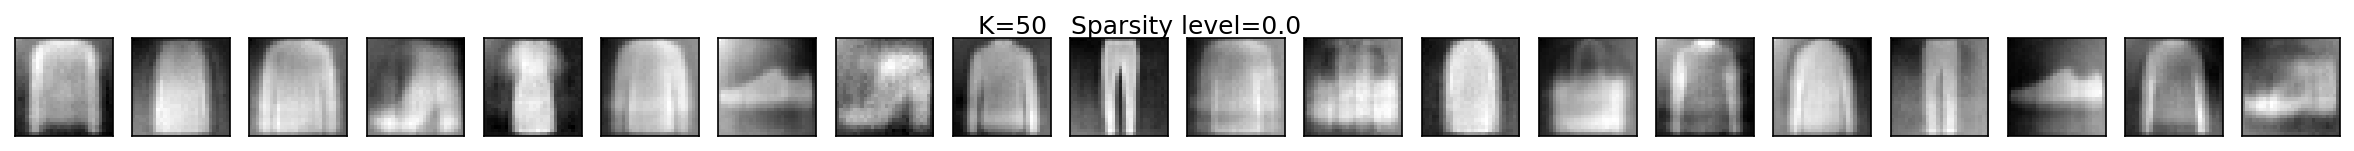

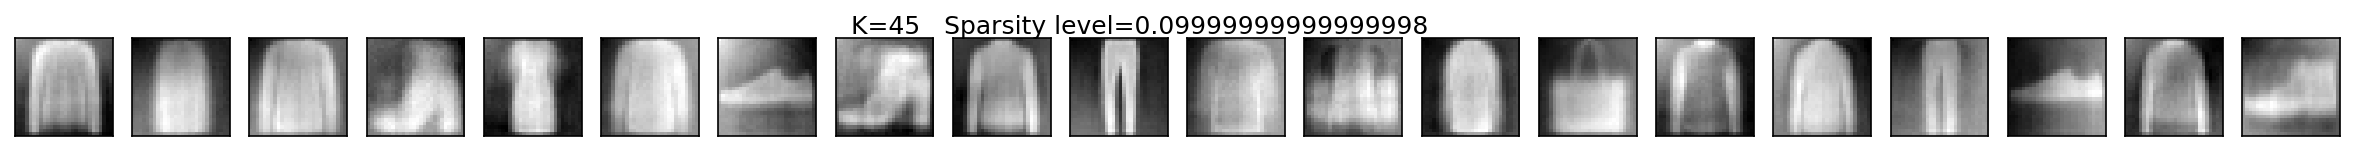

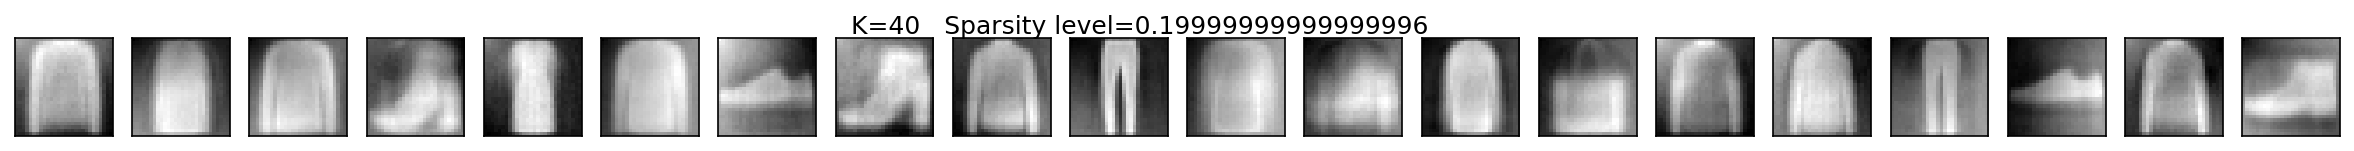

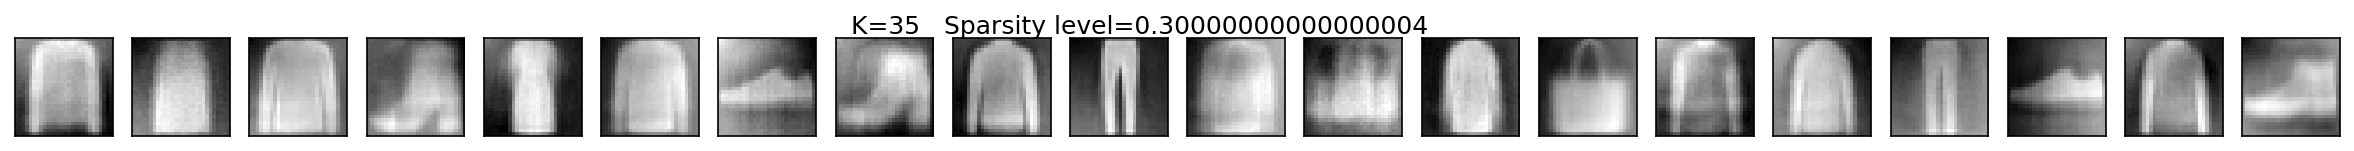

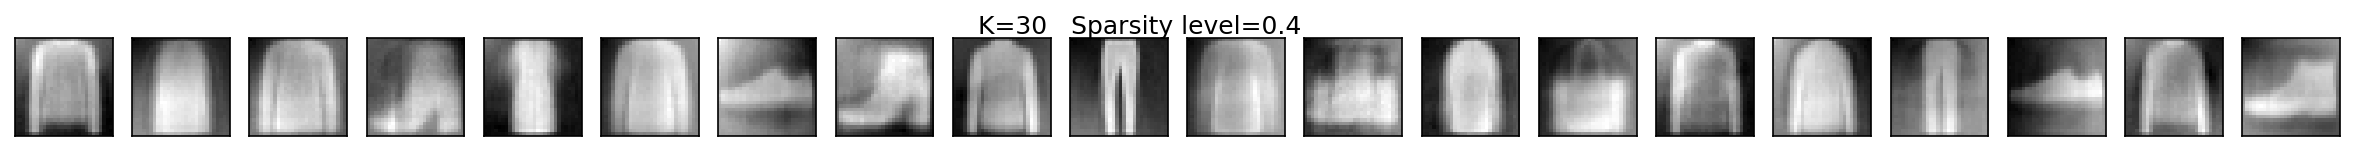

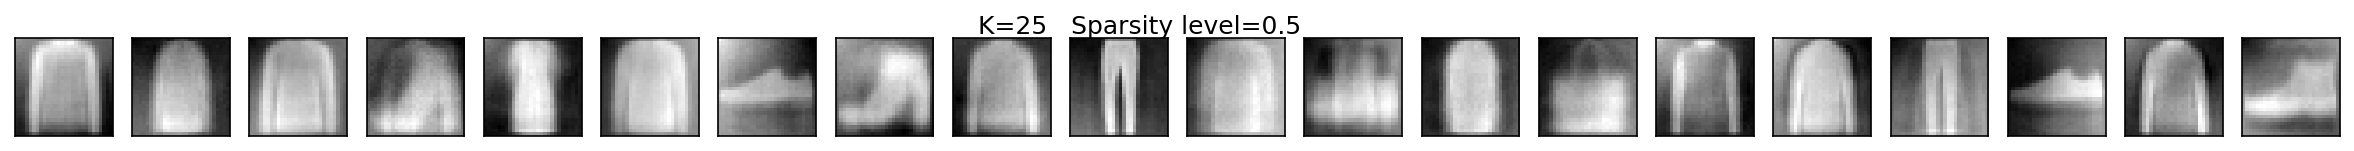

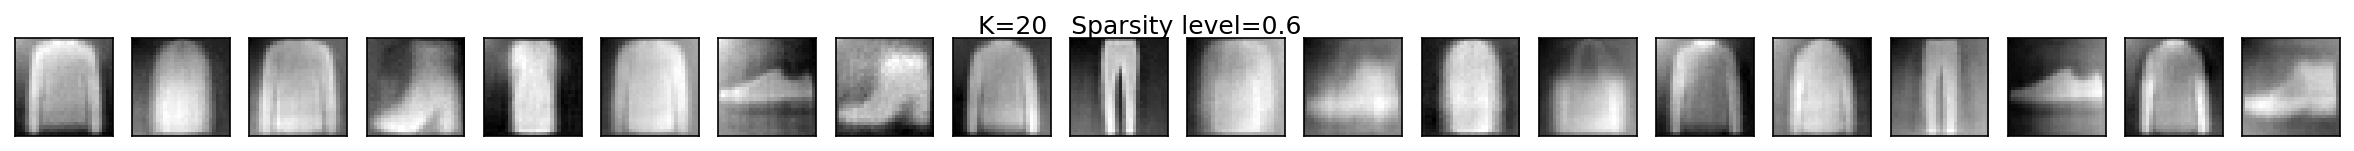

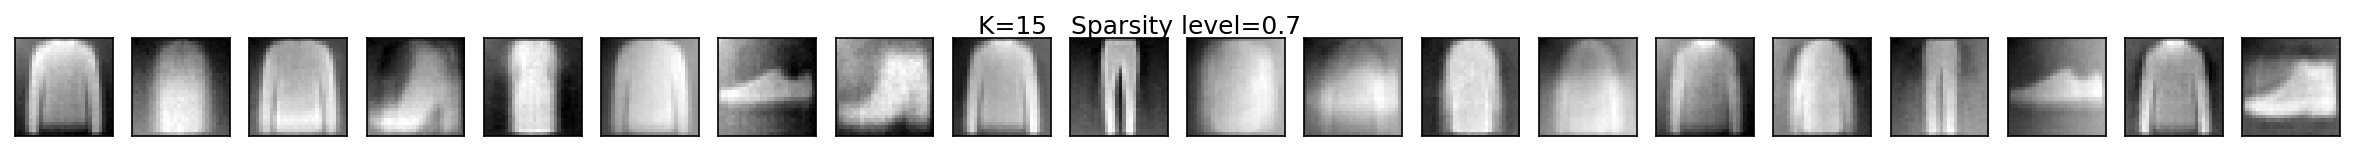

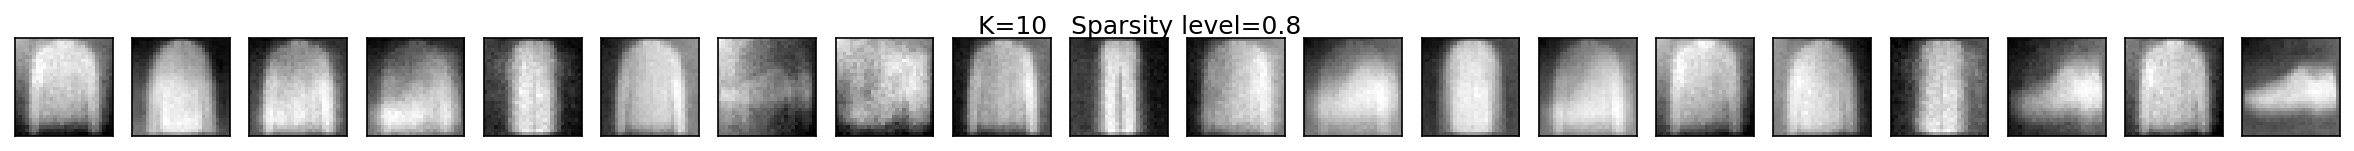

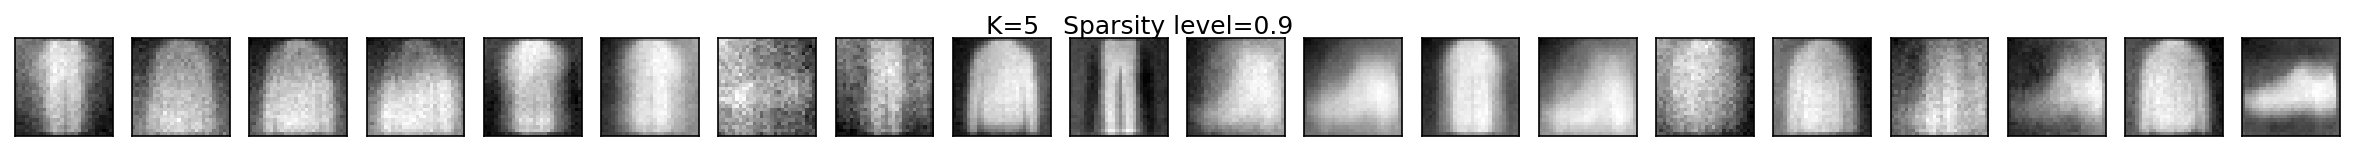

In [ ]:
plot_mnist(data.data.numpy(),"Corrupted" ,(1, 20))

for k in to_plots:
  plot_mnist(to_plots[k][0], f'K={k}   Sparsity level={1-int(k)/50}', (1, 20))

In [ ]:


# Encoder and decoder classes

class Encoder(nn.Module):
    def __init__(self, layers_dim,k):
        super(Encoder, self).__init__()
        self.layers_dim = layers_dim
        self.k=k

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            #layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        #layers.append(nn.Sigmoid())

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        encoded = self.encoder(x)

        raw=encoded.detach().numpy()

        k=self.k
        mask = np.ones(raw.shape, dtype=bool)
        if k < raw.shape[1]:
            for i, row in enumerate(raw):
                # Find the indices of the top k elements in each row
                indices = np.argpartition(row, -k)[-k:]

                # Update the mask to set elements at indices to False
                mask[i, indices] = False
                raw[i,mask[i]]=0
        return encoded
class Decoder(nn.Module):
    def __init__(self, layers_dim):
        super(Decoder, self).__init__()
        self.layers_dim = layers_dim

        layers = []
        for i in range(len(layers_dim)-2):
            layers.append(nn.Linear(layers_dim[i], layers_dim[i+1]))
            #layers.append(nn.ReLU())
        layers.append(nn.Linear(layers_dim[-2], layers_dim[-1]))
        #layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)


    def forward(self, y):
        decoded = self.decoder(y)


        return decoded


In [ ]:
# Class for autoencoder

class Net(nn.Module):
    def __init__(self, layers,k,loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.layers = layers
        self.E = Encoder(layers,k)
        self.D= Decoder(layers[::-1])
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        code = self.E(x)
        out = self.D(code)


        return out

    def decode(self, h):
        with torch.no_grad():
            decoded=self.D(h)
            return decoded


    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss






In [ ]:

layers=[28*28,128,64,50]
#models = {"15": Net(layers,15), "20": Net(layers,20),"50": Net(layers,50), "80": Net(layers,80),"128": Net(layers,128)}
models={str(k): Net(layers,k) for k in sequence}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [ ]:
models["50"]

Net(
  (E): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): Linear(in_features=128, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=50, bias=True)
    )
  )
  (D): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=50, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=128, bias=True)
      (2): Linear(in_features=128, out_features=784, bias=True)
    )
  )
)

In [ ]:
for epoch in range(1, 50):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)

    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)


Train Epoch: 1 [0/14400 (0%)]	Losses 50: 0.001515 45: 0.001645 40: 0.001664 35: 0.001822 30: 0.001945 25: 0.001877 20: 0.002045 15: 0.002343 10: 0.003482 5: 0.004612
Train Epoch: 1 [12800/14400 (89%)]	Losses 50: 0.001314 45: 0.001407 40: 0.001424 35: 0.001554 30: 0.001655 25: 0.001608 20: 0.001667 15: 0.001969 10: 0.003075 5: 0.004263
Train Epoch: 1 [14400/14400 (100%)]	Losses 50: 0.001414 45: 0.001541 40: 0.001542 35: 0.001671 30: 0.001762 25: 0.001731 20: 0.001833 15: 0.002103 10: 0.003378 5: 0.004529
Test set:
50: loss: 0.0014	
45: loss: 0.0015	
40: loss: 0.0015	
35: loss: 0.0017	
30: loss: 0.0018	
25: loss: 0.0017	
20: loss: 0.0018	
15: loss: 0.0022	
10: loss: 0.0034	
5: loss: 0.0048	

Train Epoch: 2 [0/14400 (0%)]	Losses 50: 0.001346 45: 0.001481 40: 0.001482 35: 0.001605 30: 0.001731 25: 0.001697 20: 0.001787 15: 0.002023 10: 0.003228 5: 0.004544
Train Epoch: 2 [12800/14400 (89%)]	Losses 50: 0.001413 45: 0.001523 40: 0.001549 35: 0.001673 30: 0.001841 25: 0.001788 20: 0.001847 15

In [ ]:
for k in models:
  torch.save(models[k].state_dict(), f'FashionMINST_weights_{k}_linear.pth')


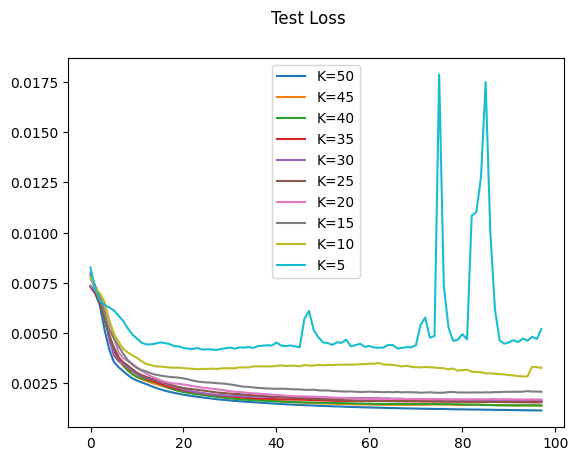

In [ ]:
for k in test_log:
    plt.plot(test_log[k], label=f'K={k}')

plt.legend()
plt.suptitle('Test Loss')
plt.show()


In [ ]:
data, _ = next(iter_data)
to_plots={k: [] for k in models}
encode={k: [] for k in models}
for k in models:
  output = models[k](data)

  to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
  to_plots[k].append(to_plot)

  x = data.view(-1, 28*28)
  encode[k].append(models[k].E(x))


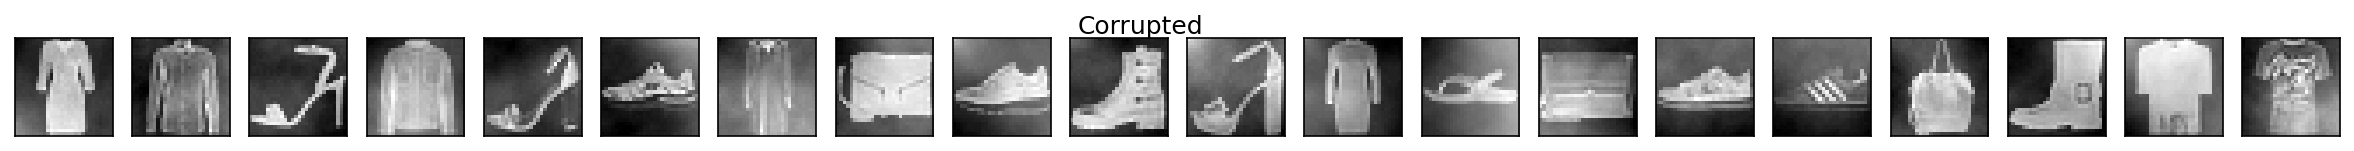

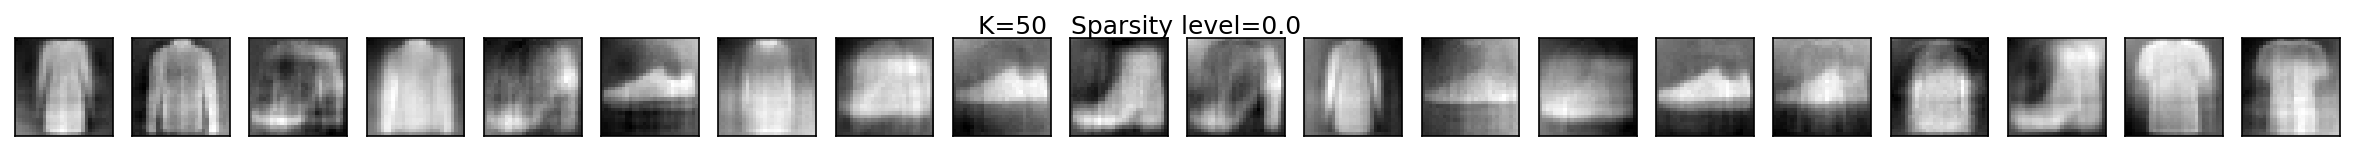

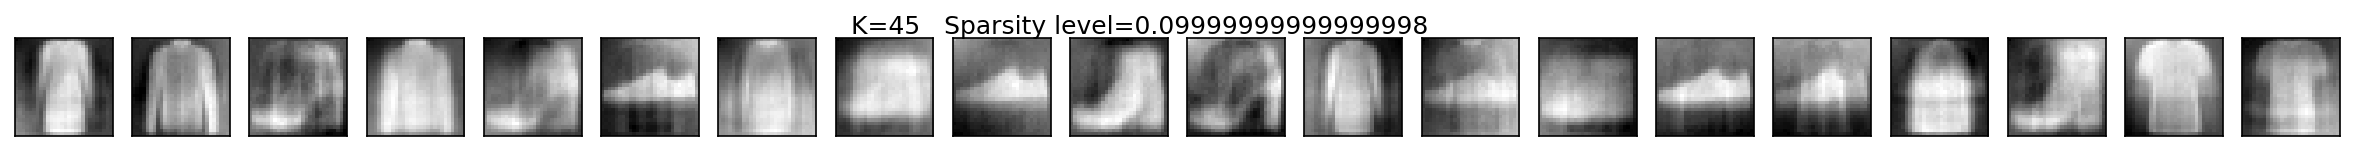

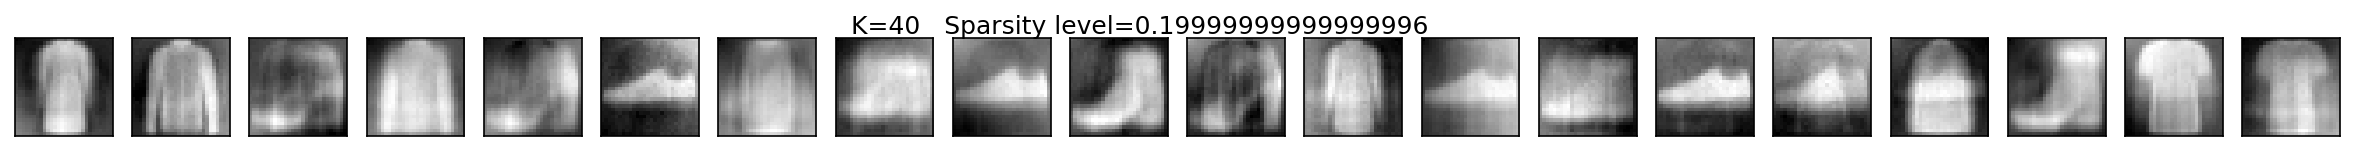

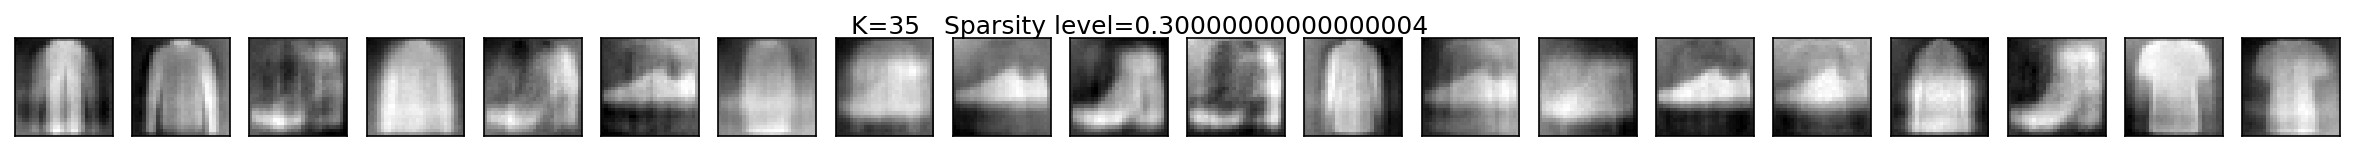

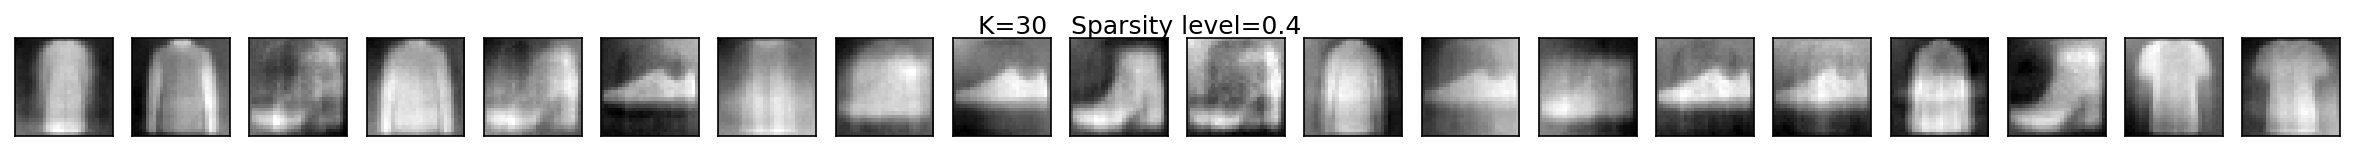

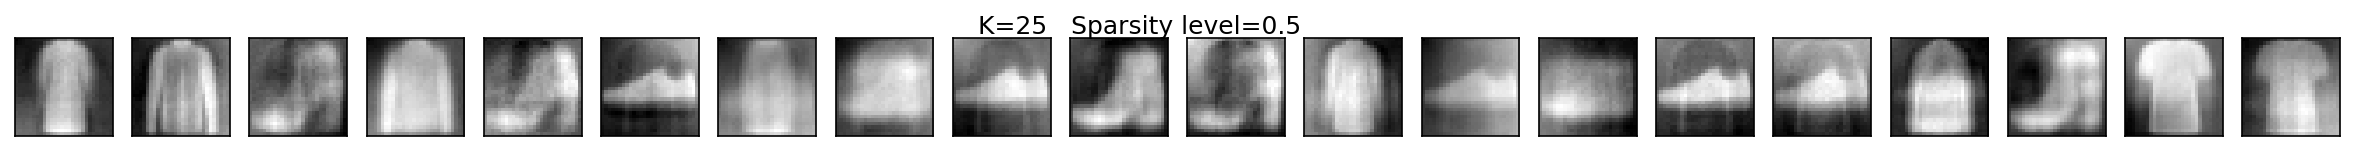

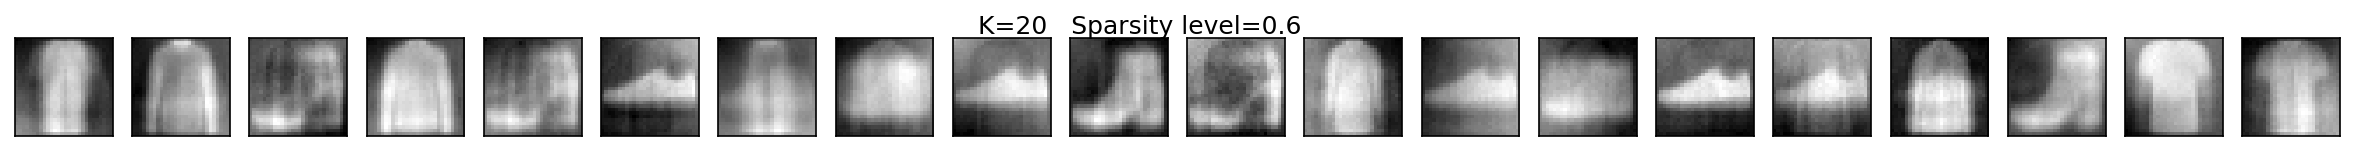

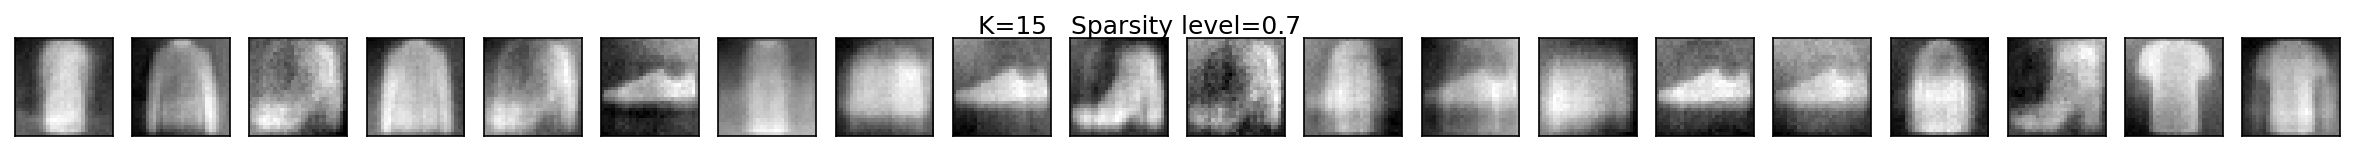

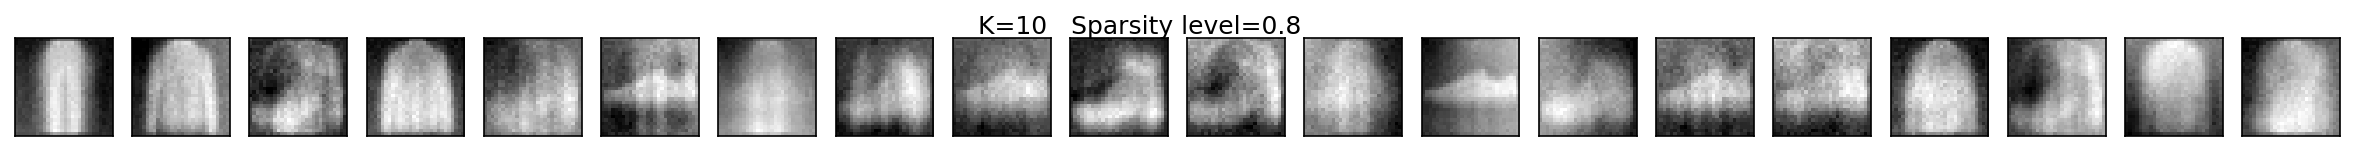

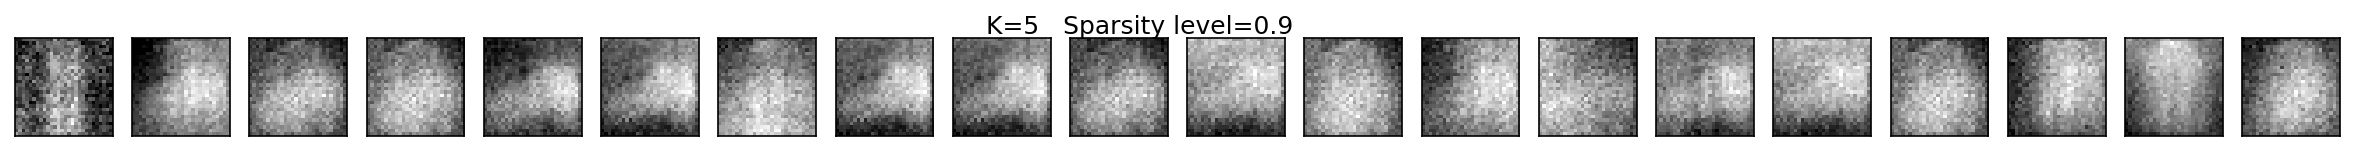

In [ ]:
plot_mnist(data.data.numpy(),"Corrupted" ,(1, 20))
for k in to_plots:
  plot_mnist(to_plots[k][0], f'K={k}   Sparsity level={1-int(k)/50}', (1, 20))